In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from eden.util import configure_logging
import logging
configure_logging(logging.getLogger(),verbosity=1)

no filter


/Library/Python/2.7/site-packages/pygraphviz/agraph.py:1281: RuntimeWarning: Fontconfig warning: ignoring UTF-8: not a valid region tag

  warnings.warn("".join(errors),RuntimeWarning)


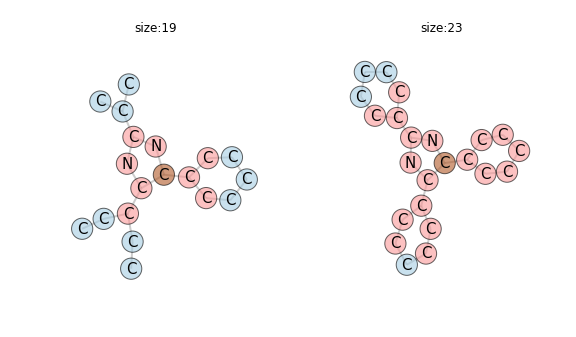

with filter: nothing should appear,,,
with filter but we chose node 2 as root


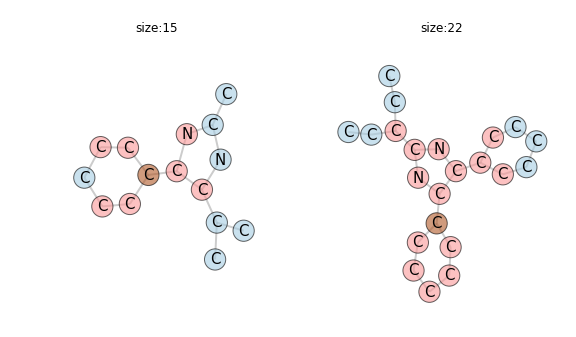

with filter but node "0" cant be part of a core, we gave 0 and 2 as radius list and only radius 2 will show up


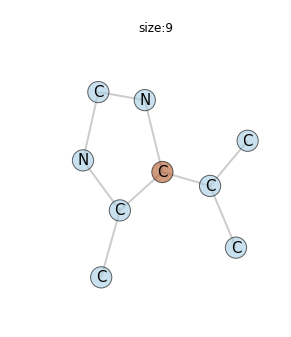

In [5]:
'''
first we test the core/interface extractor, since it is most essential
'''
import sys
sys.path.append('..')
%matplotlib inline
from eden.converter.graph.gspan import gspan_to_eden
from graphlearn import graphtools as gt
import graphlearn.utils.draw as myutils
import eden.graph as eg
import graphlearn.graphlearn as gl

#get a graph
gr = gspan_to_eden( 'bursi.pos.gspan' )
g=gr.next()

def mark_and_draw(a):
    ng=myutils.cip_to_graph(a)
    myutils.draw_graph_set(ng, 
                           n_graphs_per_line=7, size=5, 
                           colormap='Paired', invert_colormap=False,node_border=1,
                           vertex_alpha=0.6, edge_alpha=0.2, node_size=450)
    
g.node[1]['no_root']=True

#lets see.. without filter:
a=gl.extract_core_and_interface(1,g,radius_list=[2,4],thickness_list=[2],vectorizer=eg.Vectorizer())
print 'no filter'
mark_and_draw(a)


# lets do the same but with the filter
a=gl.extract_core_and_interface(1,g,radius_list=[2,4],thickness_list=[2],vectorizer=eg.Vectorizer(),filter=gt.filter)
print 'with filter: nothing should appear,,,'
mark_and_draw(a)

# filter is ignoring unfiltered things:
a=gl.extract_core_and_interface(2,g,radius_list=[2,4],thickness_list=[2],vectorizer=eg.Vectorizer(),filter=gt.filter)
print 'with filter but we chose node 2 as root'
mark_and_draw(a)


# no core attribute
g.node[0]["not_in_core"]=True
g.node[1].pop('no_root')
a=gl.extract_core_and_interface(1,g,radius_list=[0,2],thickness_list=[2],vectorizer=eg.Vectorizer(),filter=gt.filter)
print 'with filter but node "0" cant be part of a core, we gave 0 and 2 as radius list and only radius 2 will show up'
mark_and_draw(a)


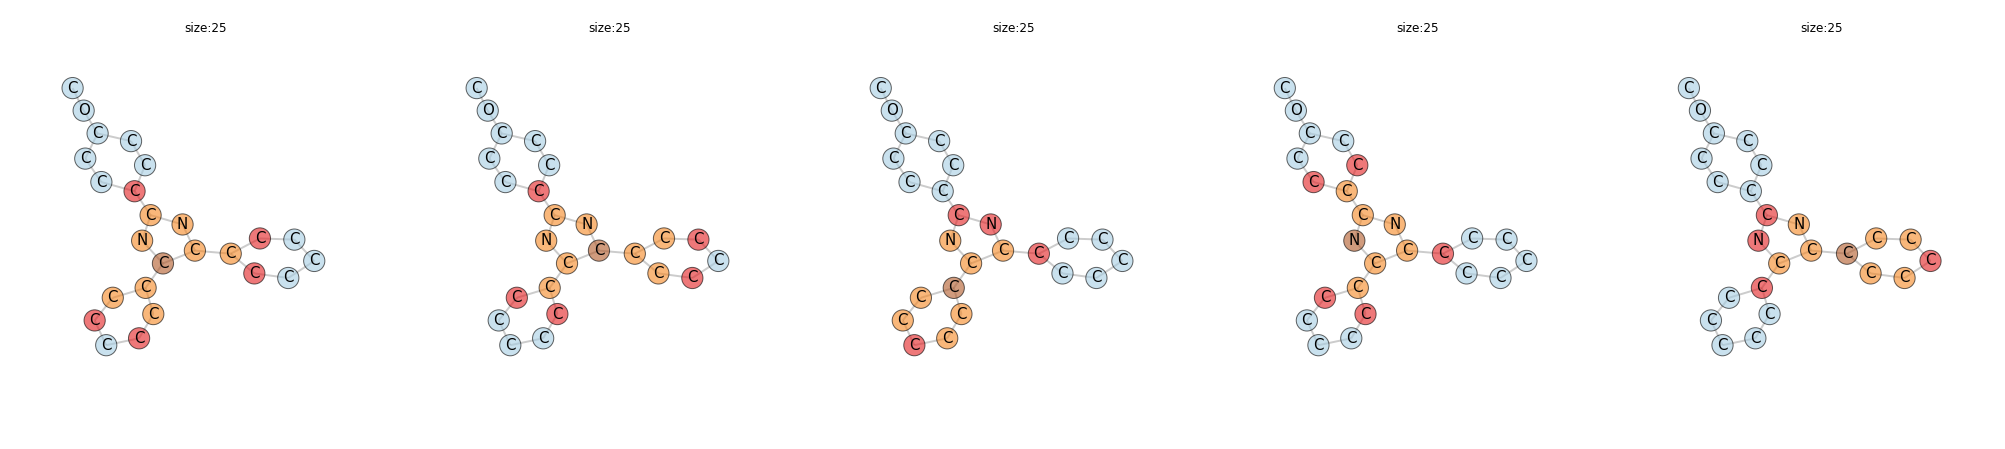

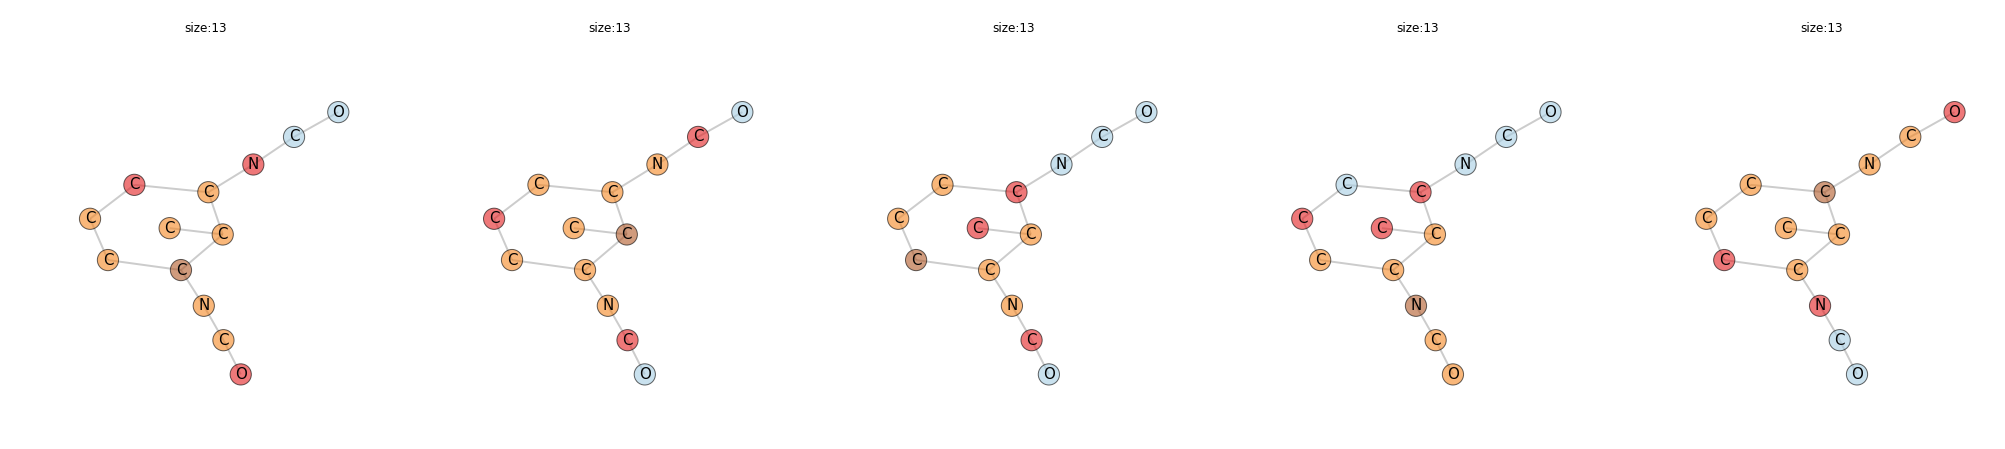

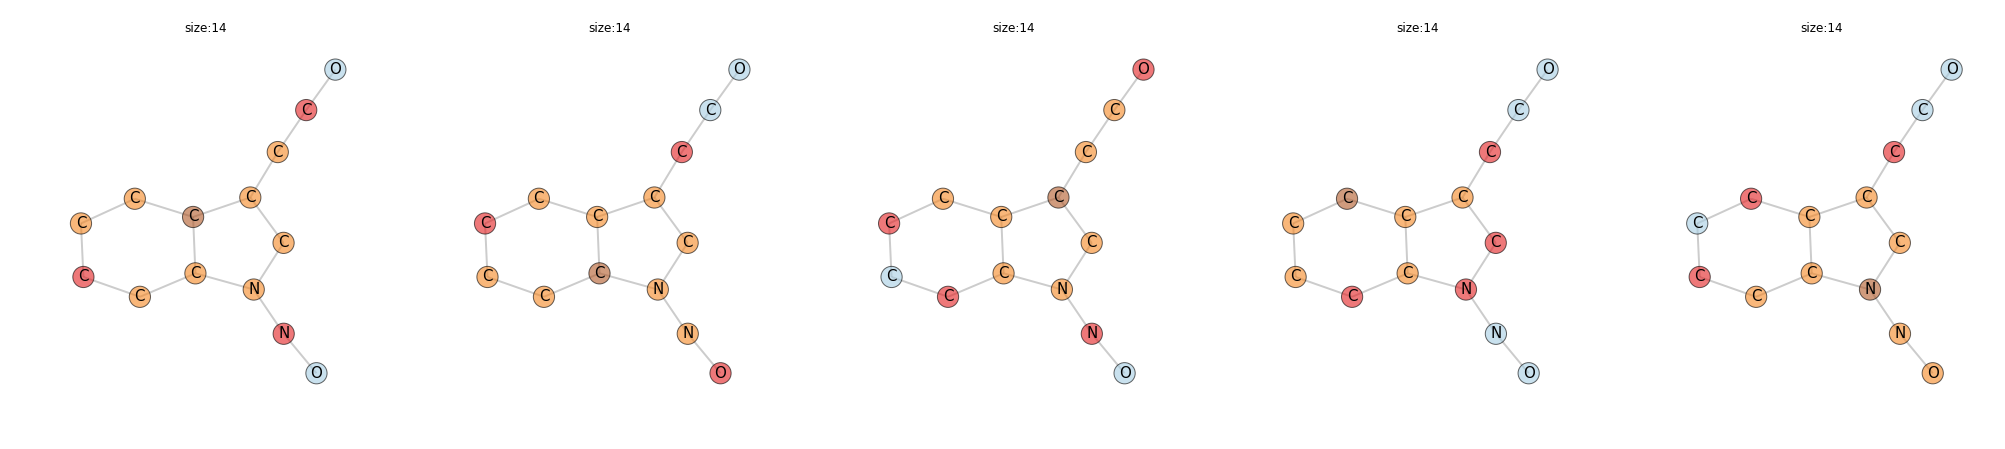

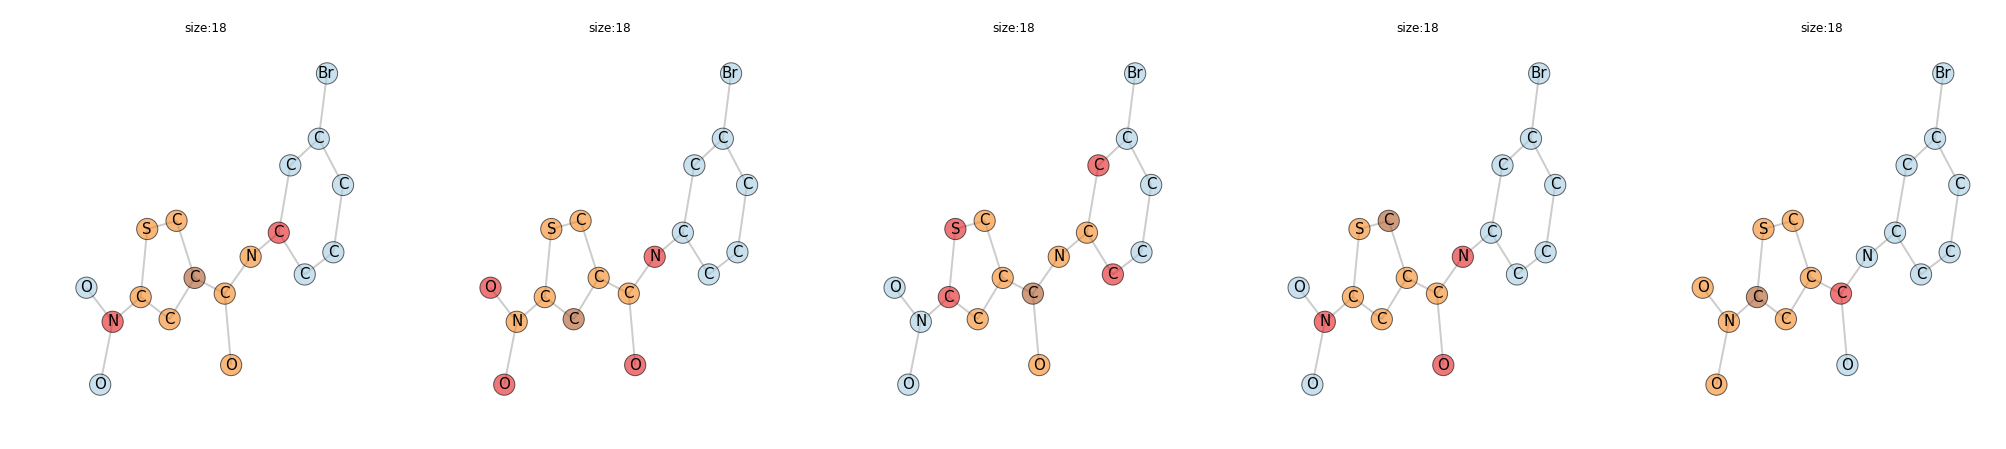

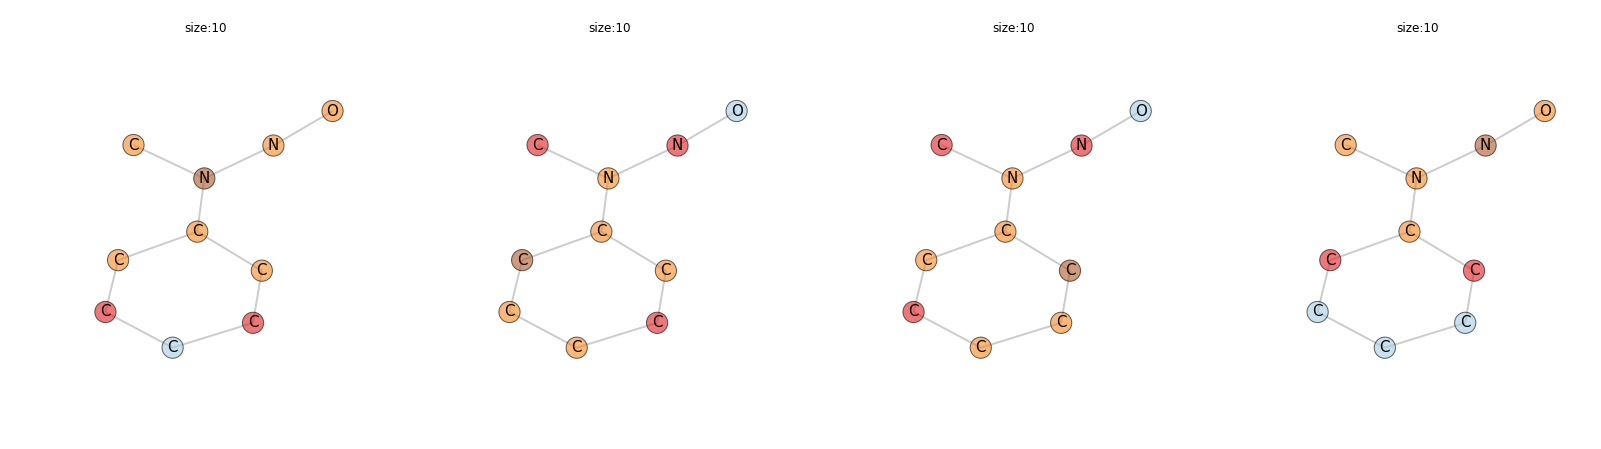

In [6]:
'''
demonstrating more extract core
'''
%matplotlib inline
import sys
sys.path.append('..')
import os
os.nice(20)
from eden.converter.graph.gspan import gspan_to_eden
import graphlearn.utils.draw as myutils
import eden.graph as eg
import graphlearn.graphlearn as gl

#get 5 grtaphs...
gr = gspan_to_eden( 'bursi.pos.gspan' )
for x in range (5):
    g=gr.next()
    # for each, pick 5 cores and extract cips 
    nice_graphs=[]
    for n in range(5):
        node=n
        a=gl.extract_core_and_interface(node,g,radius_list=[3],thickness_list=[1],vectorizer=eg.Vectorizer())
        # draw cip on the original graph and save in nice_graphs
        nice_graphs+=myutils.cip_to_graph(a, graphs=[g,g]) 
        
    # draw nice_graphs
    myutils.draw_graph_set(nice_graphs, 
                           n_graphs_per_line=5, size=7, 
                           colormap='Paired', invert_colormap=False,node_border=1,
                           vertex_alpha=0.6, edge_alpha=0.2, node_size=450)

In [7]:
%%time
'''
second is reading a grammar and training an estimator
'''
import sys
sys.path.append('..')
import os 
os.nice(20)
%matplotlib inline
import graphlearn.utils.draw as myutils
import graphlearn.graphlearn as gl
from eden.converter.graph.gspan import gspan_to_eden
import itertools

# learn a grammar
training_graphs = gspan_to_eden( 'bursi.pos.gspan' )
training_size=500
training_graphs = itertools.islice(training_graphs,training_size)
sampler=gl.GraphLearnSampler(radius_list=[1,2],thickness_list=[1,2])
sampler.fit(training_graphs,n_jobs=-1, core_interface_pair_remove_threshold=3, interface_remove_threshold=3)
sampler.save('tmp/demo.ge')

CPU times: user 28.7 s, sys: 2.7 s, total: 31.4 s
Wall time: 36.6 s


interface: 655375


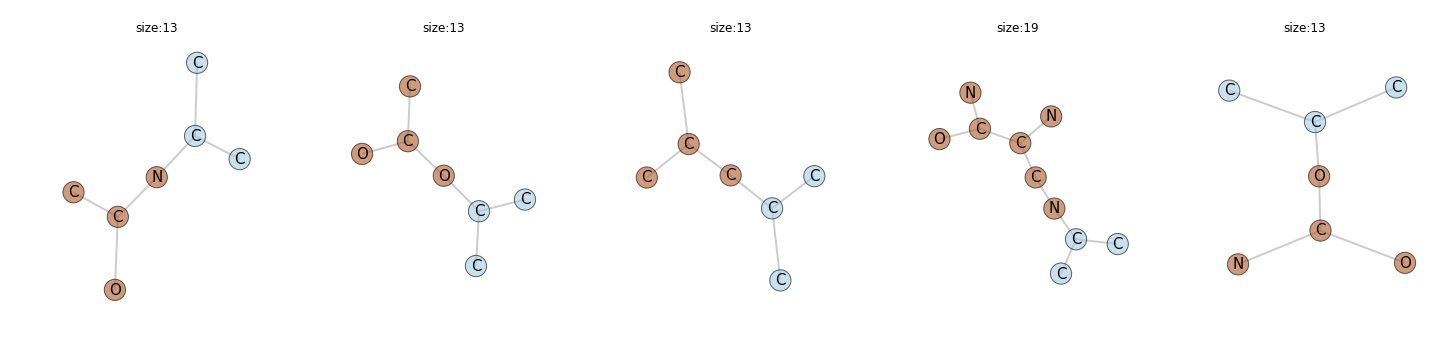

interface: 786592


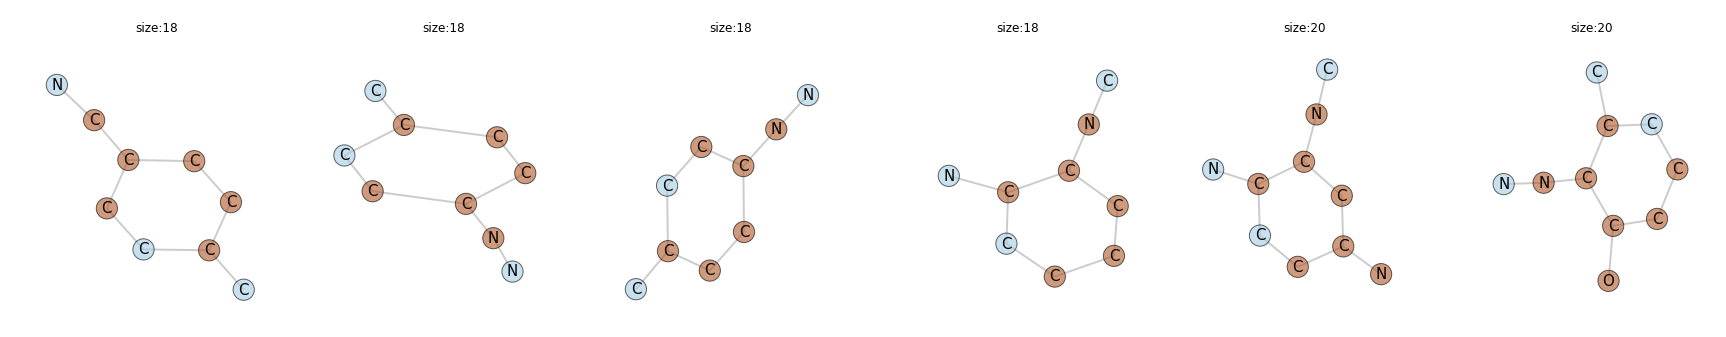

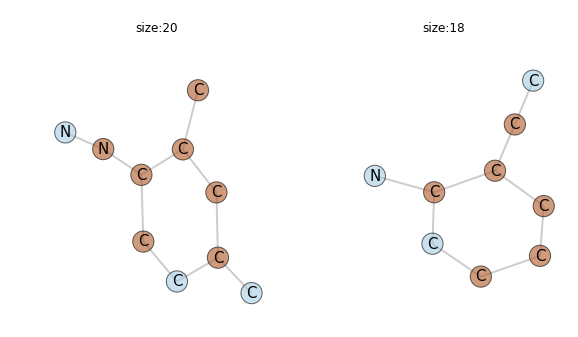

interface: 754249


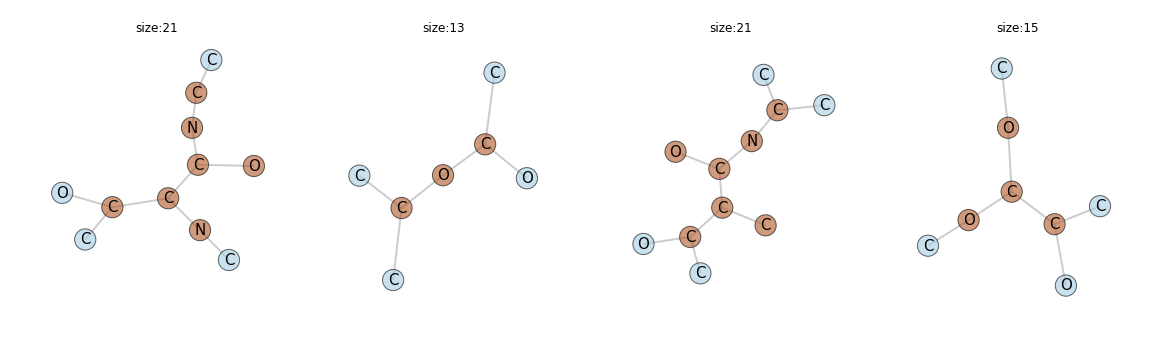

interface: 262873


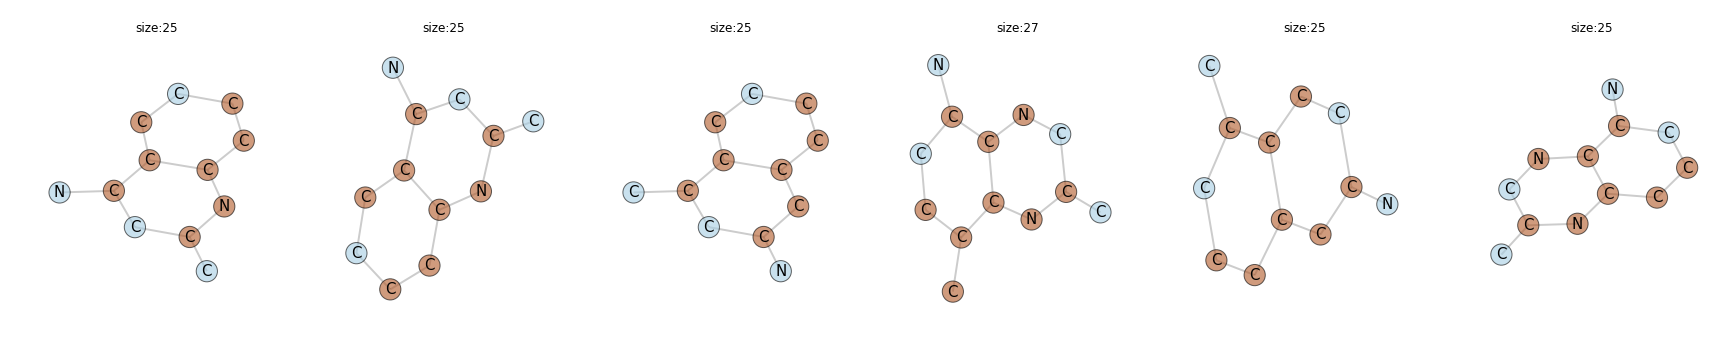

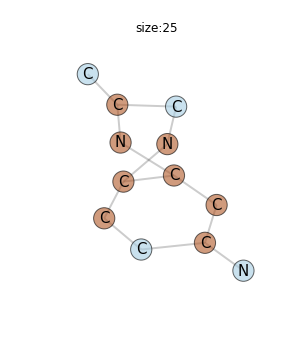

interface: 983898


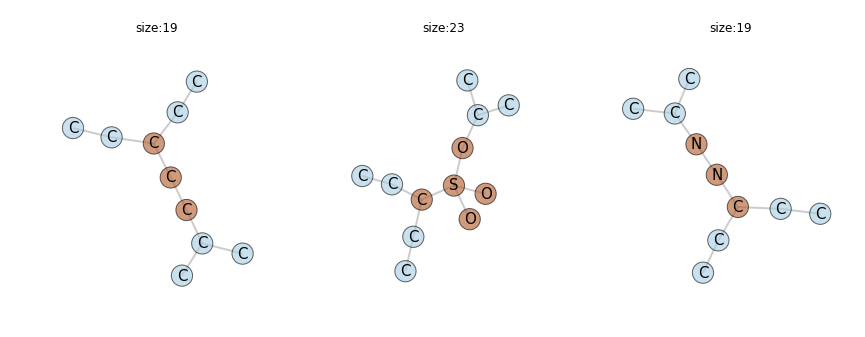

In [8]:
#draw production rules
myutils.draw_grammar(sampler.local_substitutable_graph_grammar.grammar,n_productions=5,
                     n_graphs_per_line=6, size=5, 
                     colormap='Paired', invert_colormap=False,node_border=1,
                     vertex_alpha=0.6, edge_alpha=0.2, node_size=450)

how often do we see interfacehashes
# productions: 1030
x = # interfaces (total: 156)
y=numberofcores(ihash), y=sumOfCoreCounts(ihash)


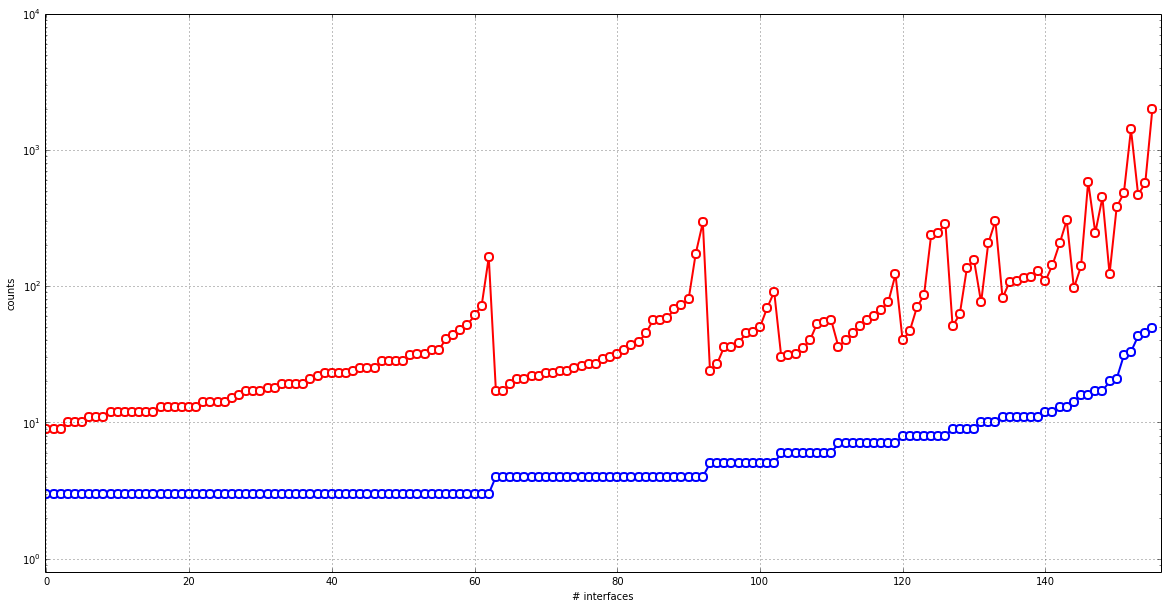

how often was this corehash seen?
x = # cores (total: 274)
y = inYinterfaces(chash), y= sumOfCountOverAllInterfaces(chash)


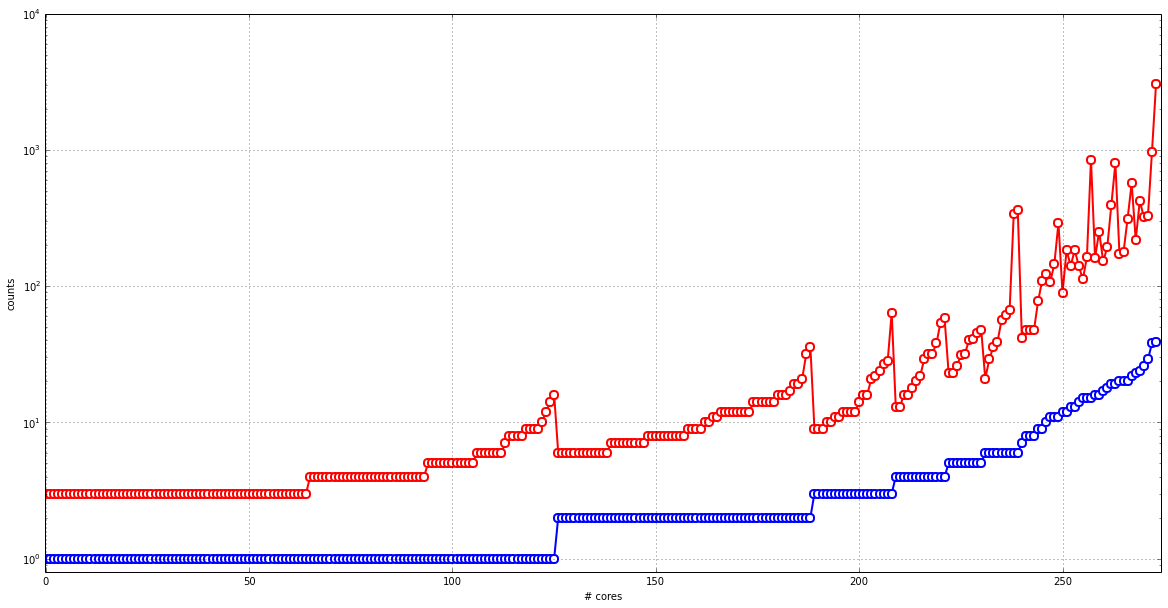

histogram
# productions: 1030
distinct cores: 274 (seen on x axis)
interfaces with x many cores were observed y many times. 


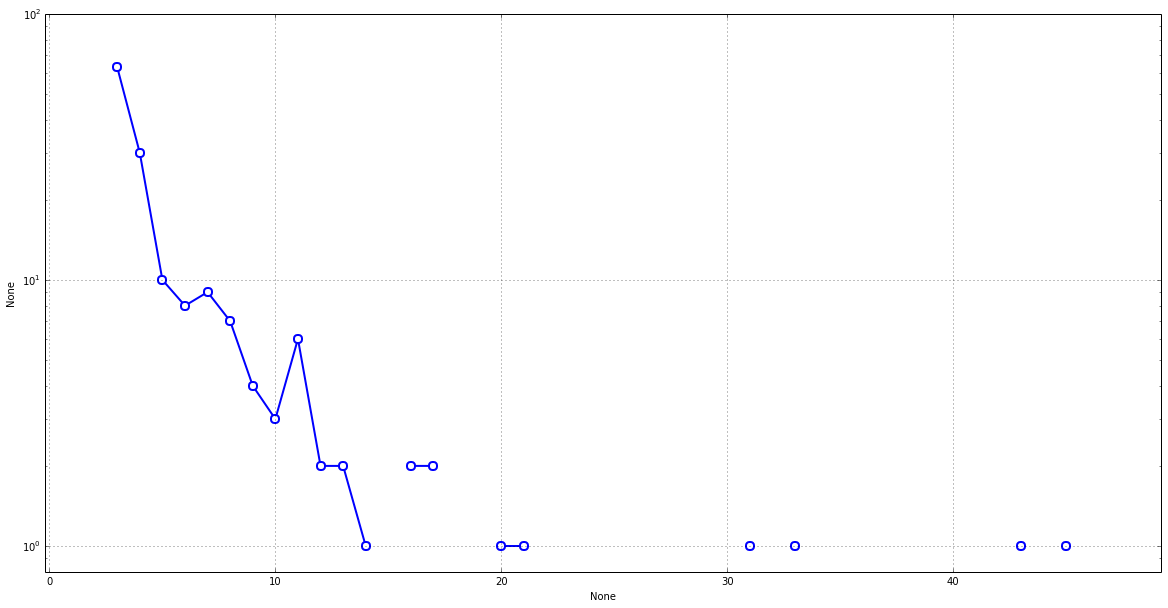

In [9]:
#grammar statistics
myutils.draw_grammar_stats(sampler.local_substitutable_graph_grammar.grammar, size=(20,10))

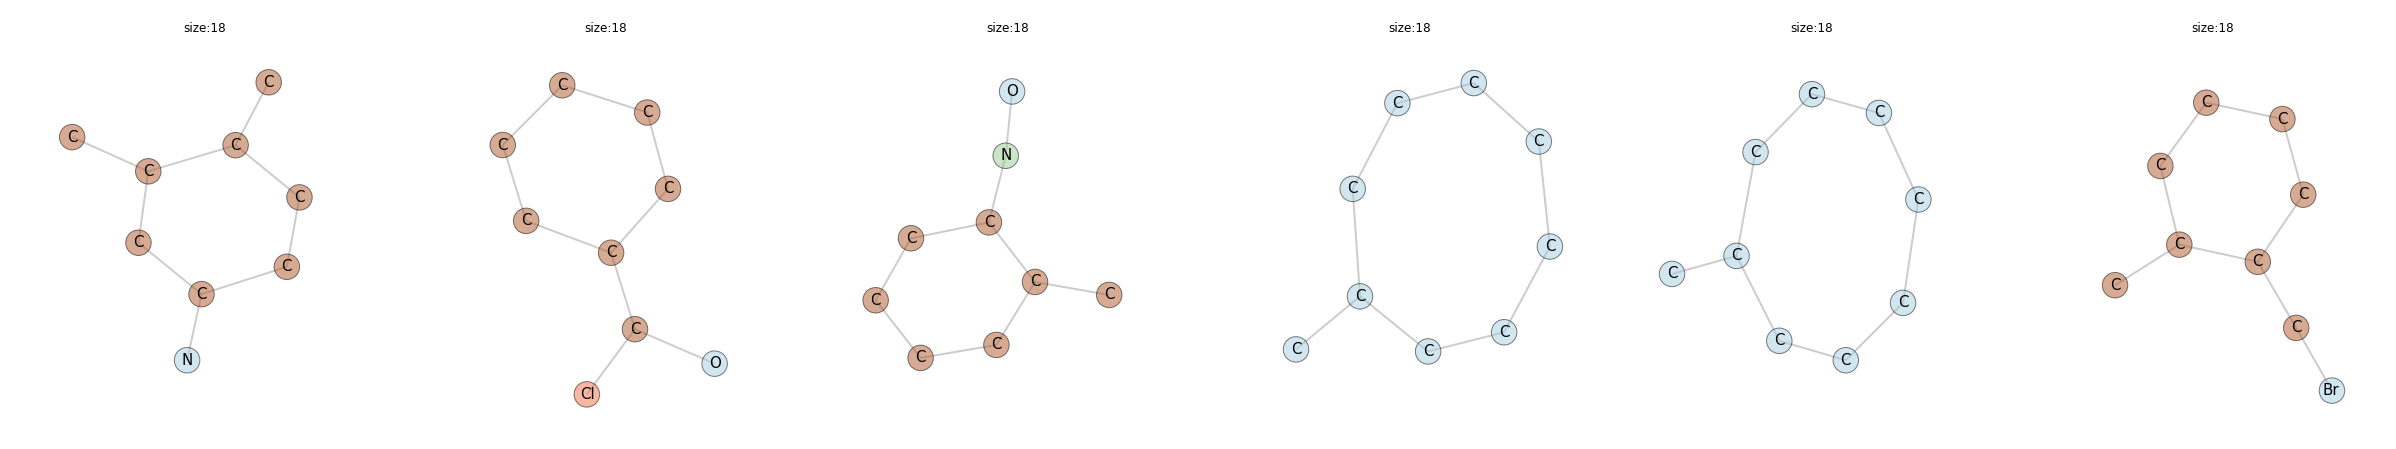

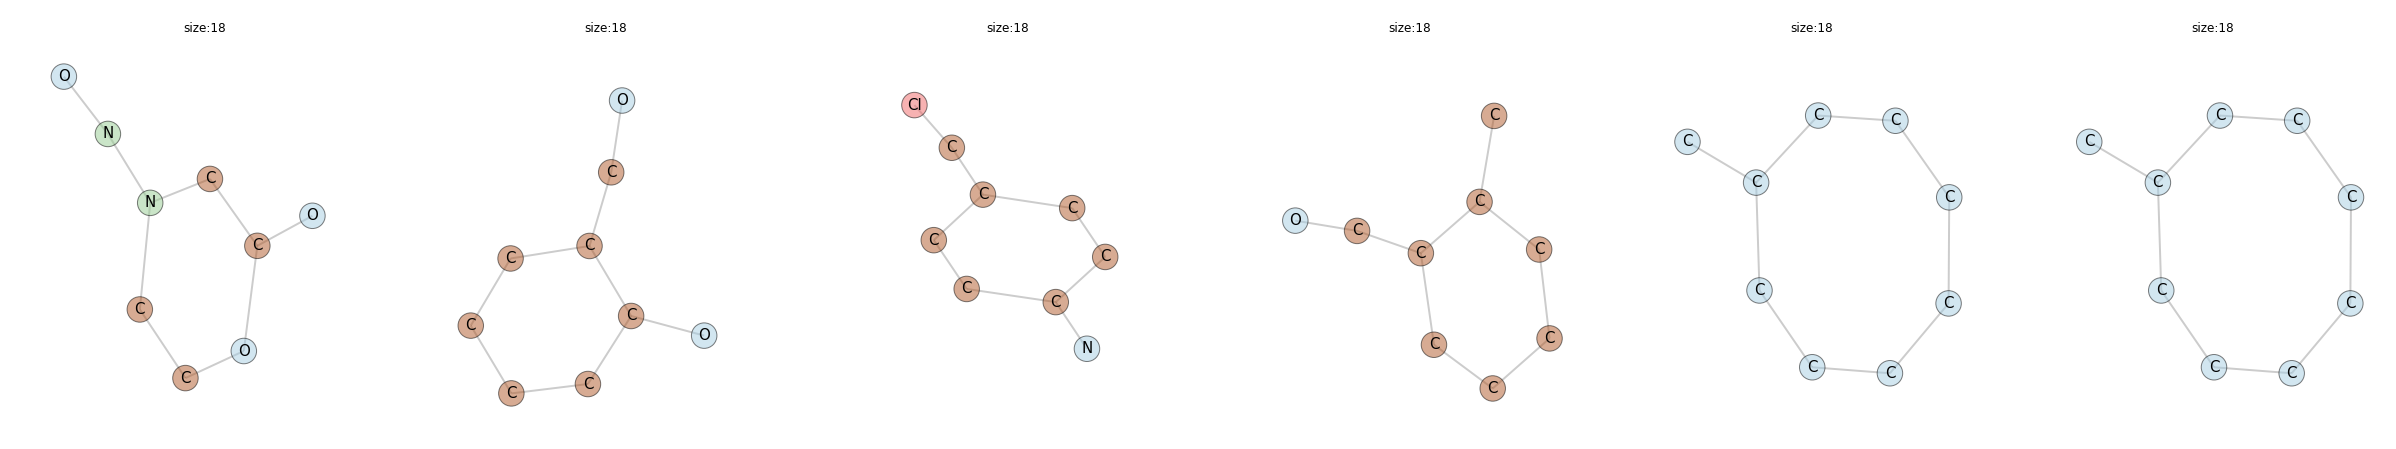

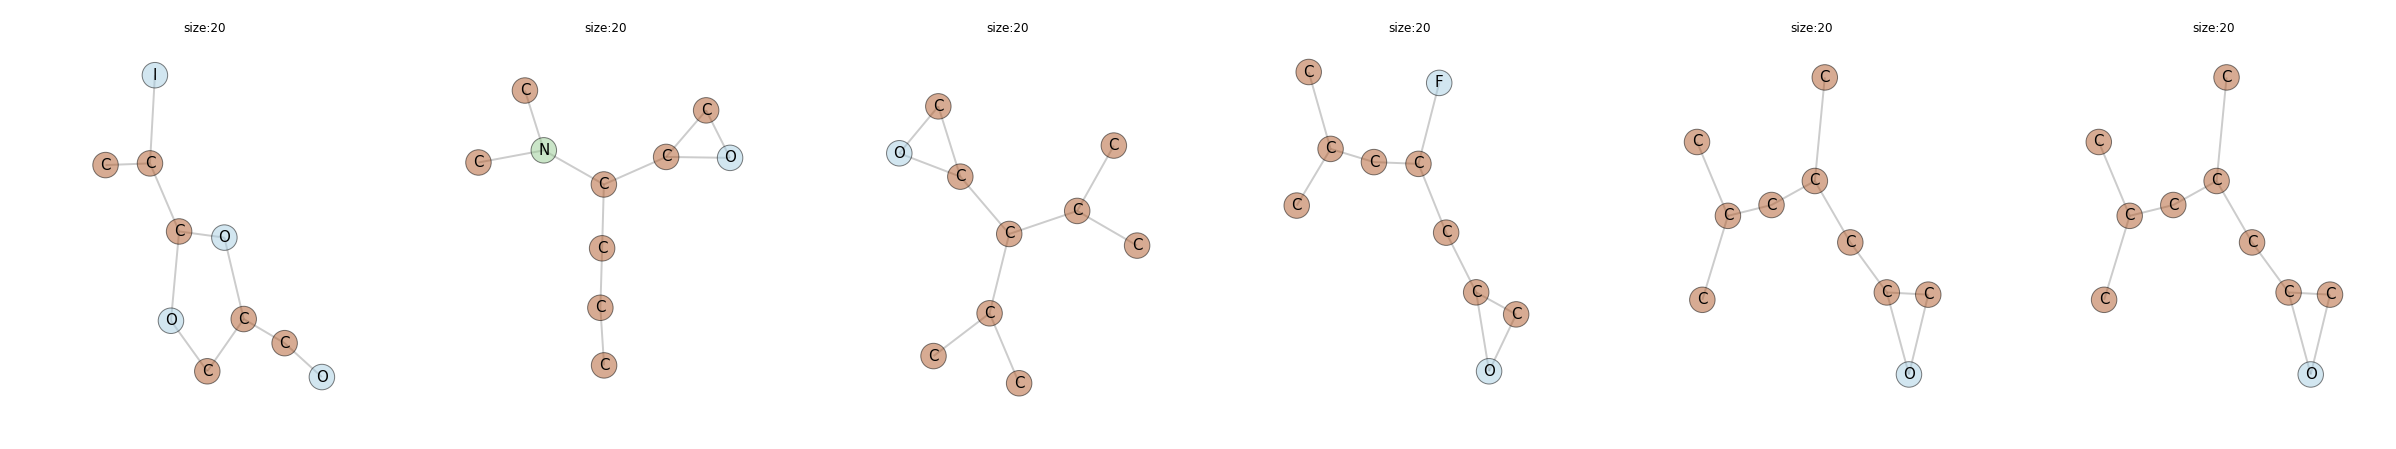

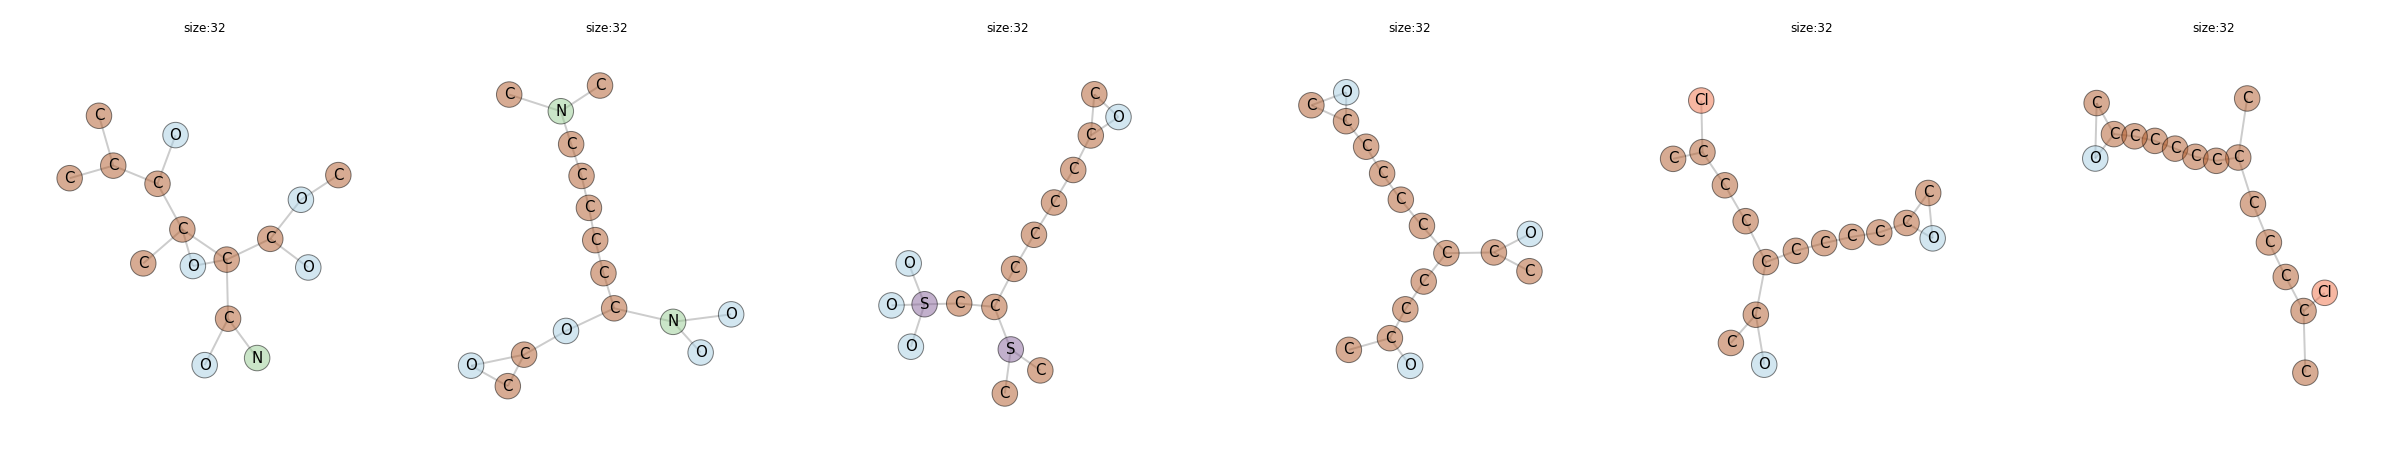

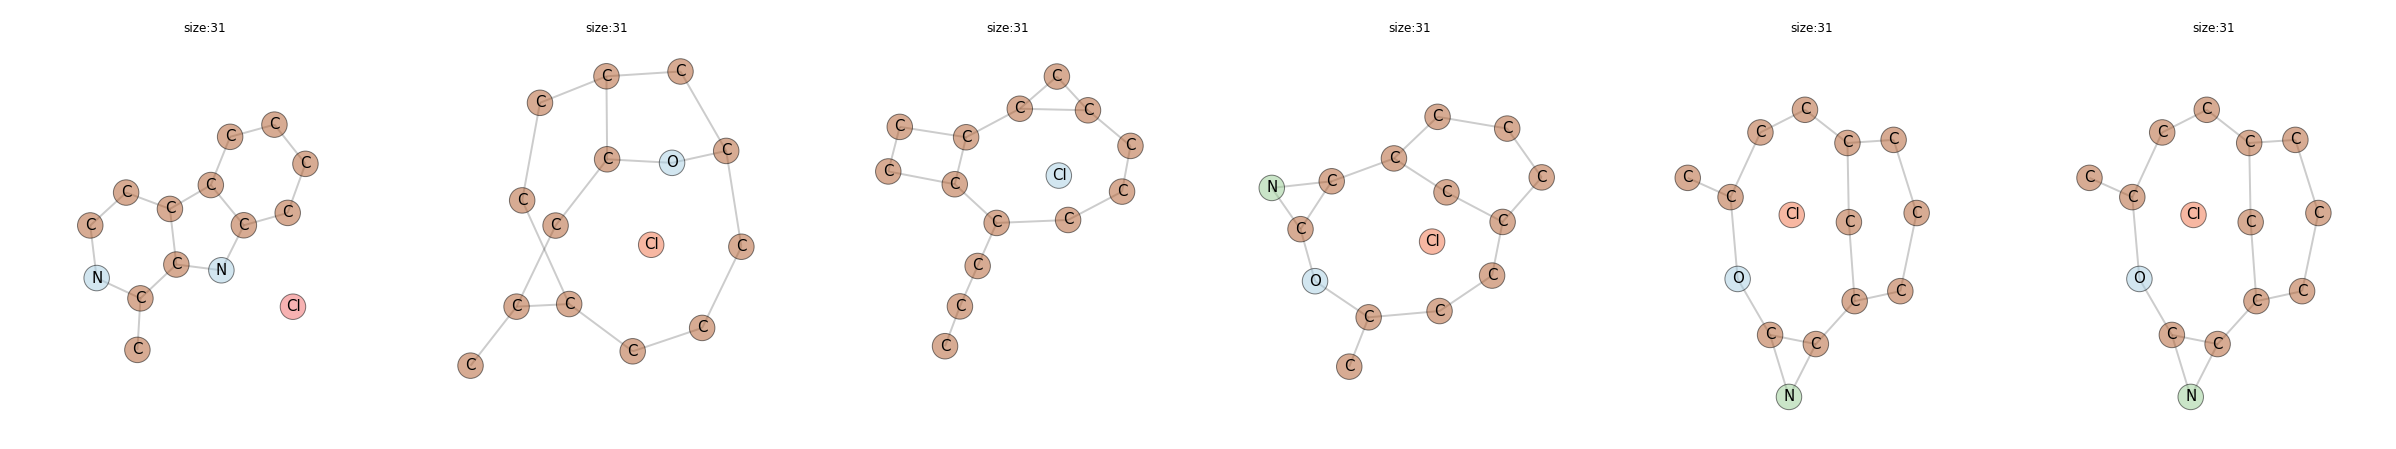

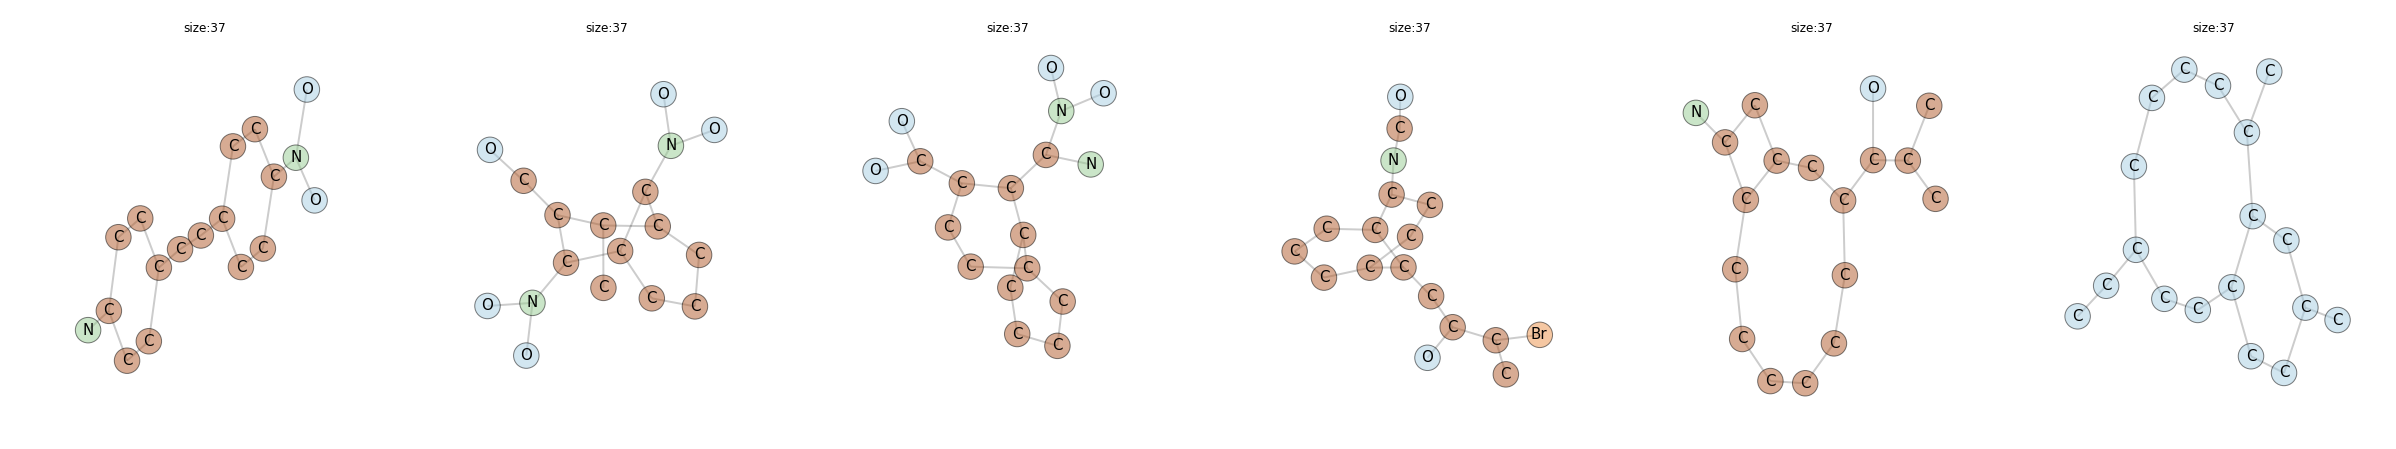

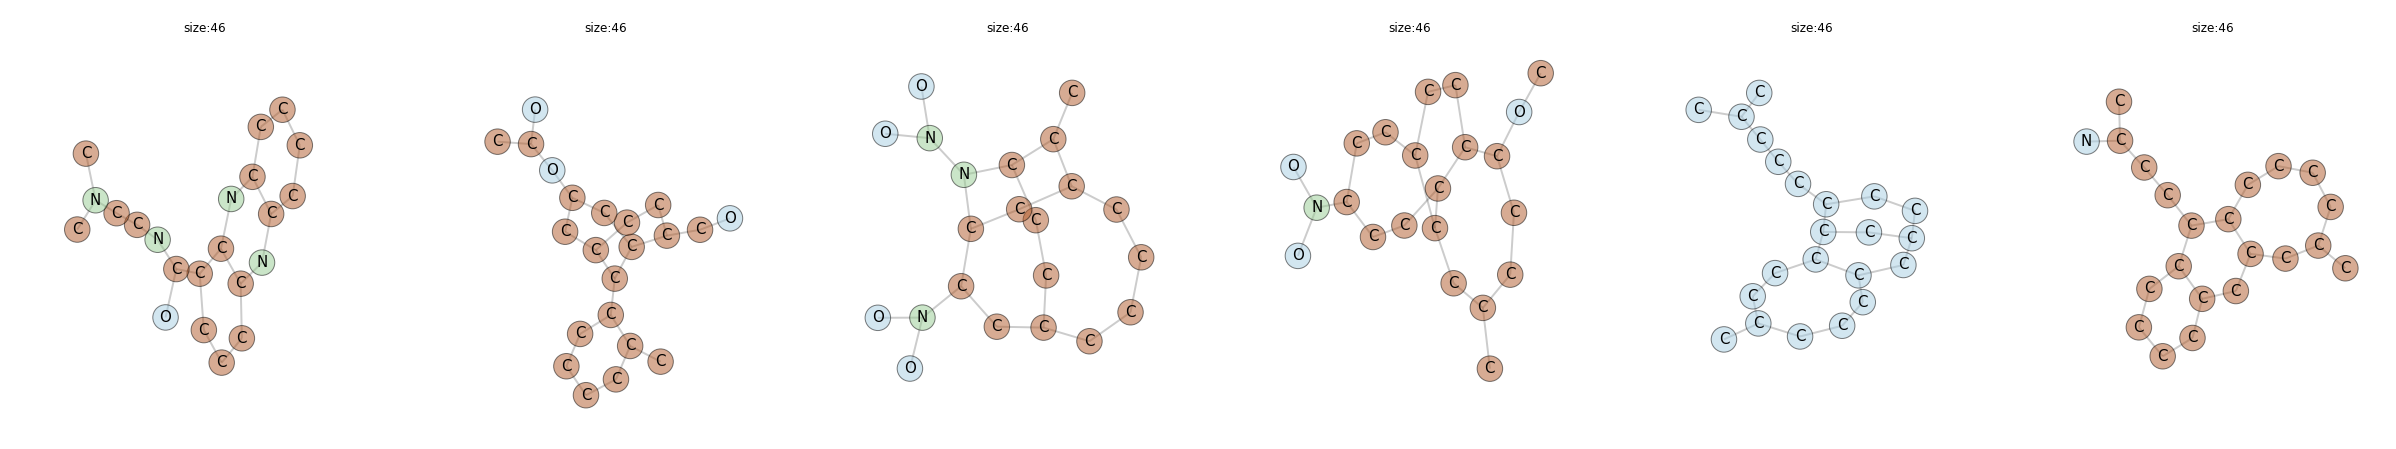

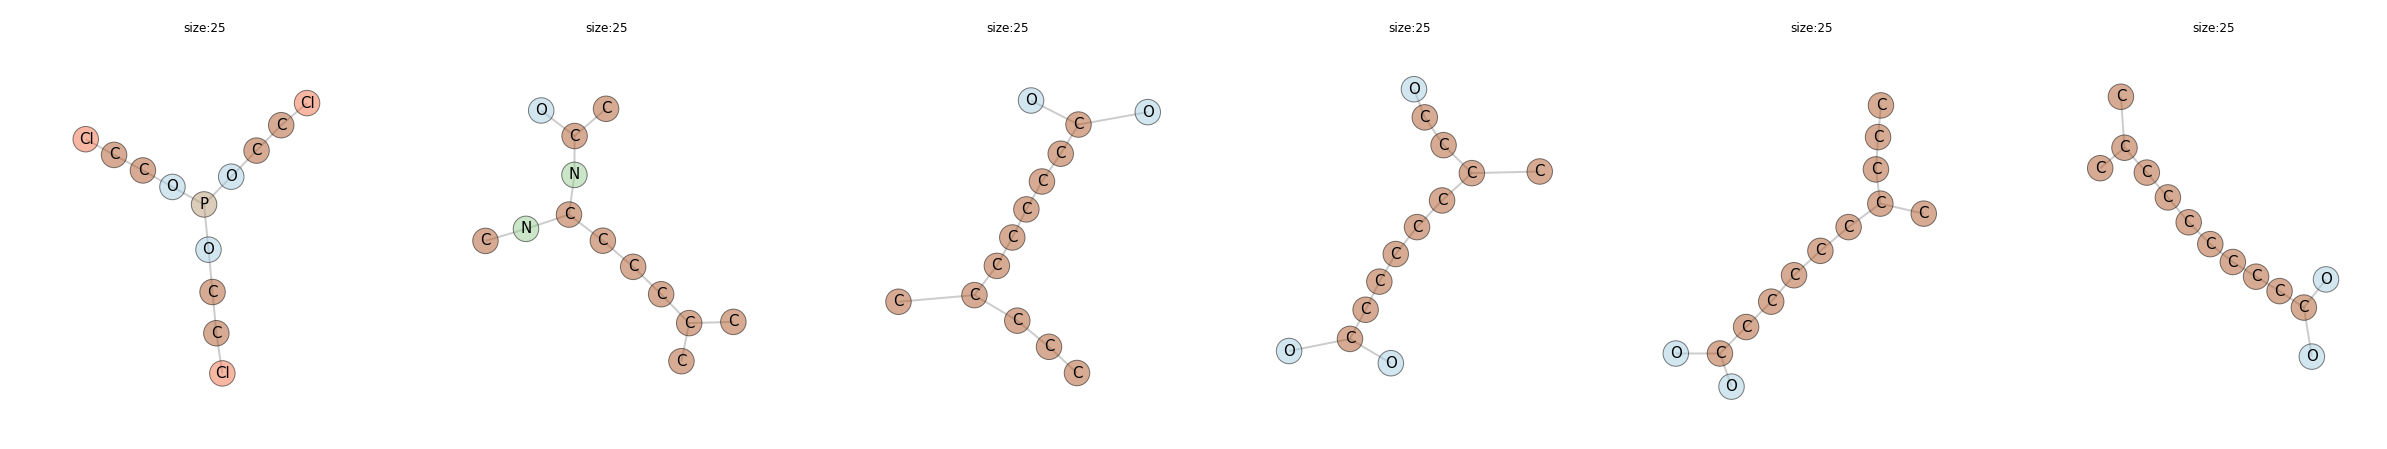

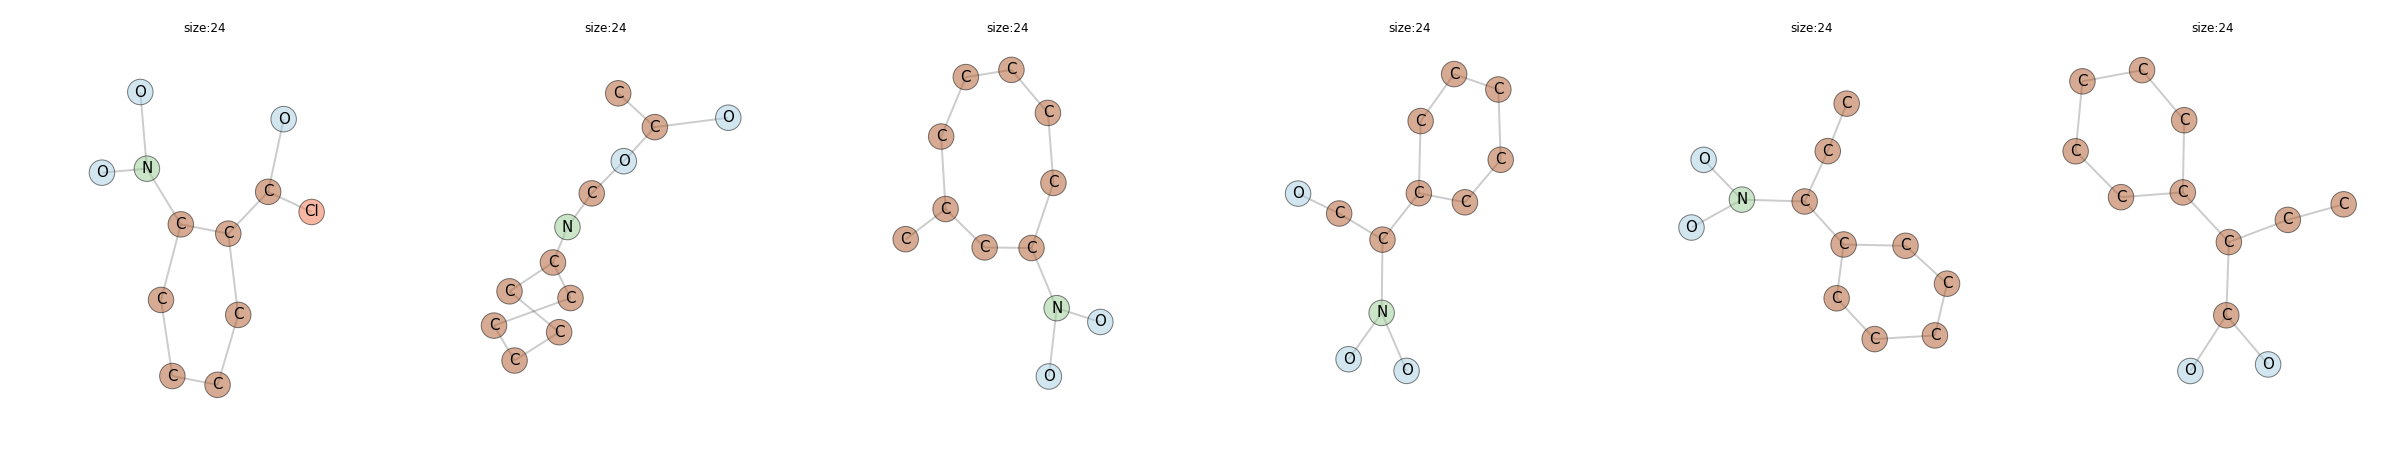

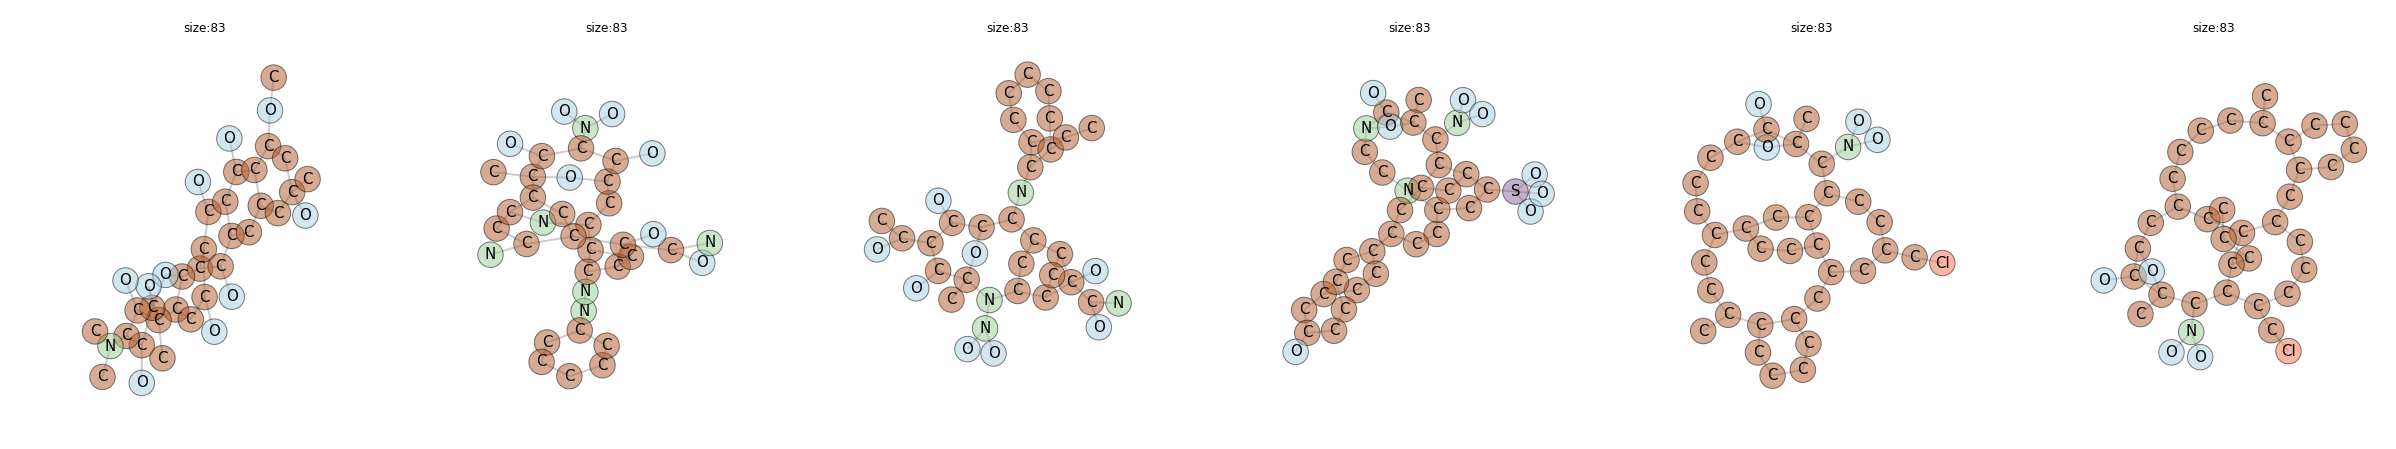

CPU times: user 21.6 s, sys: 2.36 s, total: 23.9 s
Wall time: 49.5 s


In [10]:
%%time
'''
Graph sampling
'''
import sys
sys.path.append('..')
import os
os.nice(19)
%matplotlib inline
import graphlearn.utils.draw as myutils
import graphlearn.graphlearn as gl
from eden.converter.graph.gspan import gspan_to_eden
import itertools
import matplotlib.pyplot as plt
import graphlearn.utils.draw as myutils
import eden.graph as ge

sampler=gl.GraphLearnSampler()
sampler.load('tmp/demo.ge')
graphs = gspan_to_eden( 'bursi.pos.gspan' )
id_start=20
id_end=id_start+10
graphs = itertools.islice(graphs,id_start,id_end)
n_steps=300
sampling_interval=int(n_steps/5)+1
graphs = sampler.sample(graphs,
                        same_radius=False,
                        same_core_size=True,
                        sampling_interval=sampling_interval,
                        batch_size=1,
                        n_steps=n_steps,
                        n_jobs=-1,
                        annealing_factor=1.2,
                        probabilistic_core_choice=True,
                        burnout=1,
                        select_cip_max_tries=100)

from eden.modifier.graph.vertex_attributes import colorize   
scores=[]
for graph in list(graphs):
    scores.append(graph.graph['sampling_info']['score_history'])
    path_graphs = graph.graph['sampling_info']['graphs_history']
    path_graphs = colorize(path_graphs,
                           output_attribute = 'color_level', 
                           labels = ['C','O','N','P','Cl','Br','S'])
    myutils.draw_graph_set(path_graphs,
                           n_graphs_per_line=6, size=7, 
                           colormap='Paired', invert_colormap=False,node_border=0.5, vertex_color='color_level',
                           vertex_alpha=0.5, edge_alpha=0.2, node_size=650)

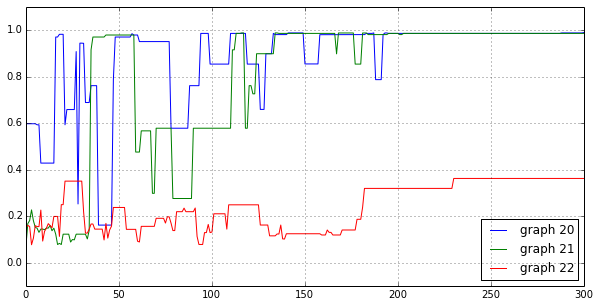

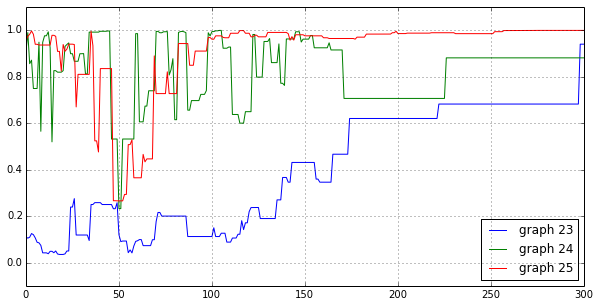

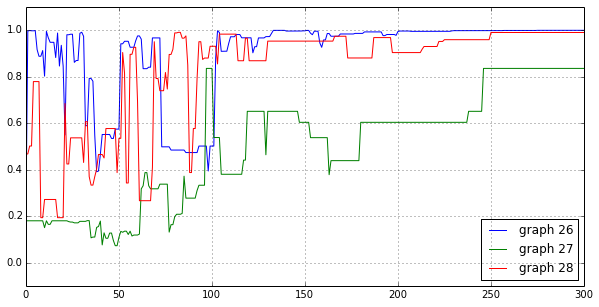

In [11]:
%matplotlib inline
from itertools import islice
import numpy as np
step=sampling_interval
step=1
num_graphs_per_plot=3
num_plots=np.ceil([len(scores)/num_graphs_per_plot])
for i in range(num_plots):
    plt.figure(figsize=(10,5))
    for j,score in enumerate(scores[i*num_graphs_per_plot:i*num_graphs_per_plot+num_graphs_per_plot]):
        data = list(islice(score,None, None, step))
        plt.plot(data, label='graph %d'%(j+i*num_graphs_per_plot+id_start))
    plt.legend(loc='lower right')
    plt.grid()
    plt.ylim(-0.1,1.1)
    plt.show()